In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from src.utils.custom_formatter import setup_custom_logger
logger = setup_custom_logger(__name__, level=logging.DEBUG)

- Load dataset to have actual returns and market returns

In [3]:
from src import Analyzer
from src.utils.params import ReturnParams

import numpy as np

return_params = ReturnParams(
    horizons={},  
    start_date=None,
    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})


ret, hor = an.build_returns()

ret = (np.exp(ret) -1)*100
ret

2025-04-30 20:41:30,778 - src.analyzer - INFO - ############################## Analysis Started ############################## (analyzer.py:80)
2025-04-30 20:41:39,801 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:172)


,rh_portfolio
date,
2018-05-03,-0.602745
2018-05-04,1.683162
2018-05-07,0.852330
2018-05-08,0.413330
2018-05-09,1.028846
...,...
2020-01-28,1.713913
2020-01-29,-0.579647
2020-01-30,-0.322621


In [4]:
import pandas as pd
from config.constants import PROJECT_ROOT

daily_factors = pd.read_csv(f"{PROJECT_ROOT}/jf-datashare/gabriel-cuevas/data/18_rwarh_d_1.csv", index_col=0)
daily_factors.index = pd.to_datetime(daily_factors.index, format="%Y%m%d")
daily_factors[["pfioret100", "xmkt", "rf"]]



daily_factors = daily_factors.merge(ret["rh_portfolio"], left_index=True, right_index=True, how="inner")
daily_factors /= 100 

daily_factors["xr"] = daily_factors["rh_portfolio"] - daily_factors["rf"]
daily_factors += 1

daily_factors = daily_factors[["xr", "xmkt"]]
daily_factors


,xr,xmkt
2018-06-04,1.007919,1.0048
2018-06-05,1.007607,1.0016
2018-06-06,1.009507,1.0086
2018-06-07,0.995381,0.9986
2018-06-08,1.003415,1.0031
...,...,...
2020-01-28,1.017079,1.0102
2020-01-29,0.994144,0.9990
2020-01-30,0.996714,1.0034
2020-01-31,0.981644,0.9826


In [5]:
#monthly_factors = pd.read_csv(f"{PROJECT_ROOT}/jf-datashare/gabriel-cuevas/data/20_rwarh_m_1.csv", index_col=0)
#monthly_factors["xr"] = monthly_factors["pfioret100"] - monthly_factors["rf"]
#monthly_factors = monthly_factors[["xr", "xmkt"]]
#monthly_factors.index = pd.to_datetime(monthly_factors.index, format="%Y%m")
monthly_returns = (daily_factors).resample("M").prod() - 1
monthly_returns += 1
monthly_returns



,xr,xmkt
2018-06-30,1.008236,0.994128
2018-07-31,0.995874,1.032174
2018-08-31,1.070942,1.041184
2018-09-30,1.006036,1.000871
2018-10-31,0.893139,0.923333
2018-11-30,0.999990,1.016996
2018-12-31,0.890604,0.904717
2019-01-31,1.131084,1.066421
2019-02-28,1.054940,1.033878
2019-03-31,1.008846,1.010808


Gamma: -7.0344


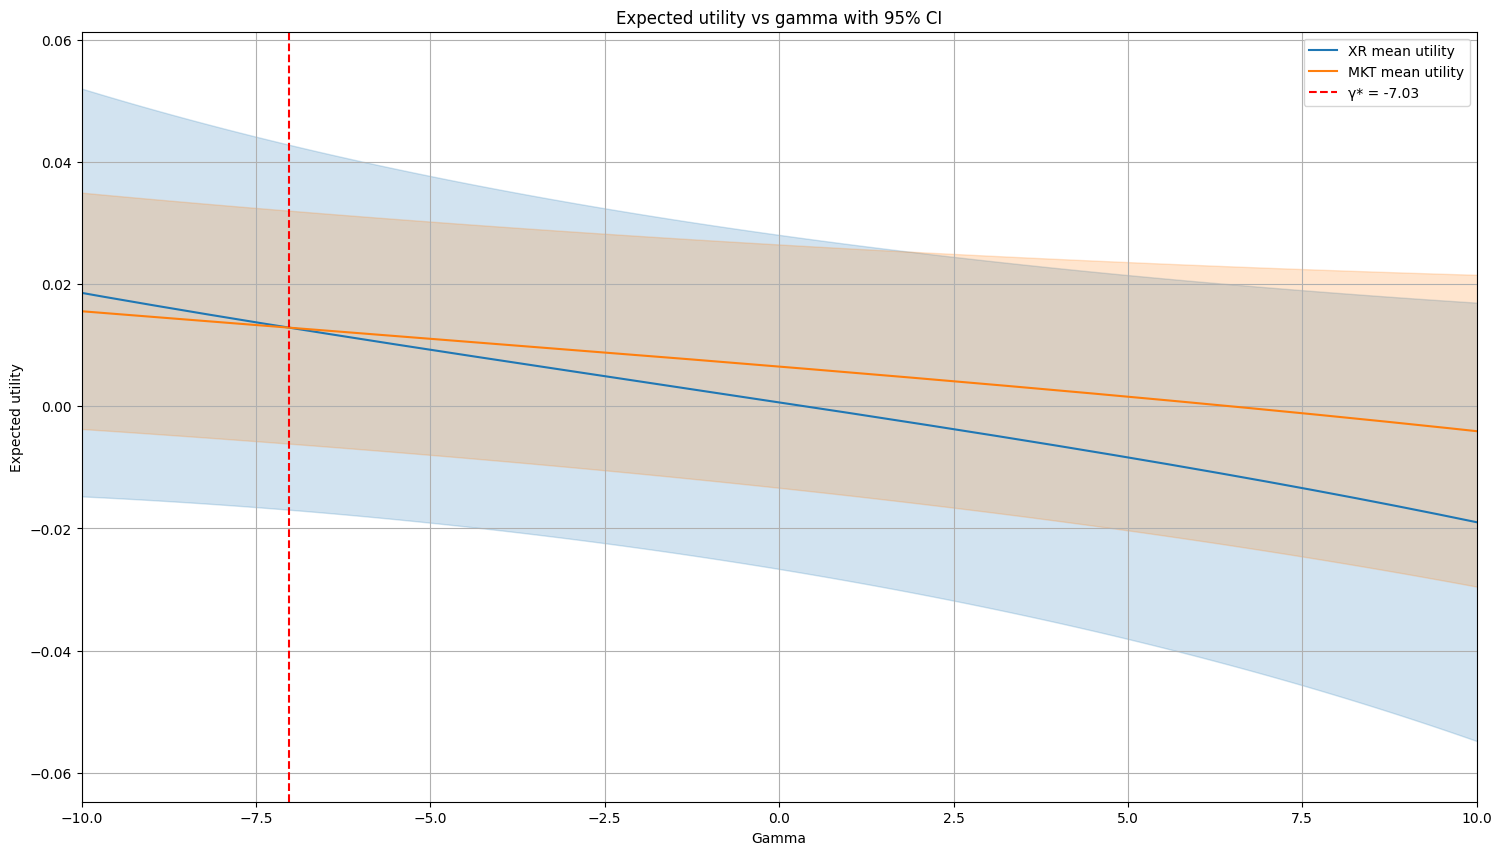

In [6]:
from src.utils.metrics import find_gamma_certainty_equivalent, paramteric_expected_utility_crra, compute_crra_utility


df = monthly_returns
parametric = False



import numpy as np
import matplotlib.pyplot as plt

# keep the scalar returned by the CE condition
gamma_hat = find_gamma_certainty_equivalent(df["xr"],
                                            df["xmkt"],
                                            parametric=parametric)

print(f"Gamma: {gamma_hat:.4f}")

gap = 5
gammas = np.linspace(-11, 11, 1000)

if parametric:
    utilities_xr   = [paramteric_expected_utility_crra(g, df["xr"].values)   for g in gammas]
    utilities_xmkt = [paramteric_expected_utility_crra(g, df["xmkt"].values) for g in gammas]
    plt.figure(figsize=(10, 6))
    plt.plot(gammas, utilities_xr,   label='Portfolio')
    plt.plot(gammas, utilities_xmkt, label='Market')
    plt.axvline(gamma_hat, color='red', linestyle='--', alpha=0.6,
                label=f'γ* = {gamma_hat:.3f}')
    plt.xlabel('Gamma (relative risk-aversion parameter)')
    plt.ylabel('Expected CRRA utility')
    plt.title('Expected utility as a function of gamma')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    utilities_xr   = [compute_crra_utility(df["xr"],   g, confint=True) for g in gammas]
    utilities_xmkt = [compute_crra_utility(df["xmkt"], g, confint=True) for g in gammas]

    means_xr, lo_xr, hi_xr = zip(*utilities_xr)
    means_mk, lo_mk, hi_mk = zip(*utilities_xmkt)

    # Plot
    import matplotlib.pyplot as plt

    plt.figure(figsize=(18,10))
    plt.plot(gammas, means_xr, label='XR mean utility', color='C0')
    plt.fill_between(gammas, lo_xr, hi_xr, color='C0', alpha=0.2)

    plt.plot(gammas, means_mk, label='MKT mean utility', color='C1')
    plt.fill_between(gammas, lo_mk, hi_mk, color='C1', alpha=0.2)

    plt.axvline(gamma_hat, color='red', linestyle='--', label=f'γ* = {gamma_hat:.2f}')
    plt.xlabel('Gamma')
    plt.xlim((-10,10))
    plt.ylabel('Expected utility')
    plt.title('Expected utility vs gamma with 95% CI')
    plt.legend()
    plt.grid(True)
    plt.show()




### All possible timeframes

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams

import numpy as np

return_params = ReturnParams(
    horizons={},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})


rt = RiskTests(an)



2025-05-02 02:07:17,883 - src.analyzer - INFO - ############################## Analysis Started ############################## (analyzer.py:80)
2025-05-02 02:07:21,178 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:172)
2025-05-02 02:07:21,508 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:172)


In [11]:
all_ret_df = rt.build_all_pairs_dataframe()
all_ret_df.describe()

100%|██████████| 144991/144991 [00:18<00:00, 8031.76it/s] 


,rh_portfolio,rf,mkt,xr,xmkt,date_difference
count,144991.000000,144991.000000,144991.000000,144991.000000,144991.000000,144991.000000
mean,1.004986,1.013605,1.042531,0.991762,1.028400,269.754799
std,0.138991,0.010031,0.095739,0.138892,0.092365,190.278126
min,0.576651,1.000000,0.657317,0.560197,0.656392,1.000000
25%,0.934533,1.004842,0.990825,0.921485,0.979591,109.000000
50%,0.996995,1.011879,1.041799,0.984986,1.029788,238.000000
75%,1.069755,1.021334,1.100916,1.057228,1.083484,403.000000
max,2.028748,1.035970,1.549780,2.027677,1.549235,801.000000


Gamma: -5.23917


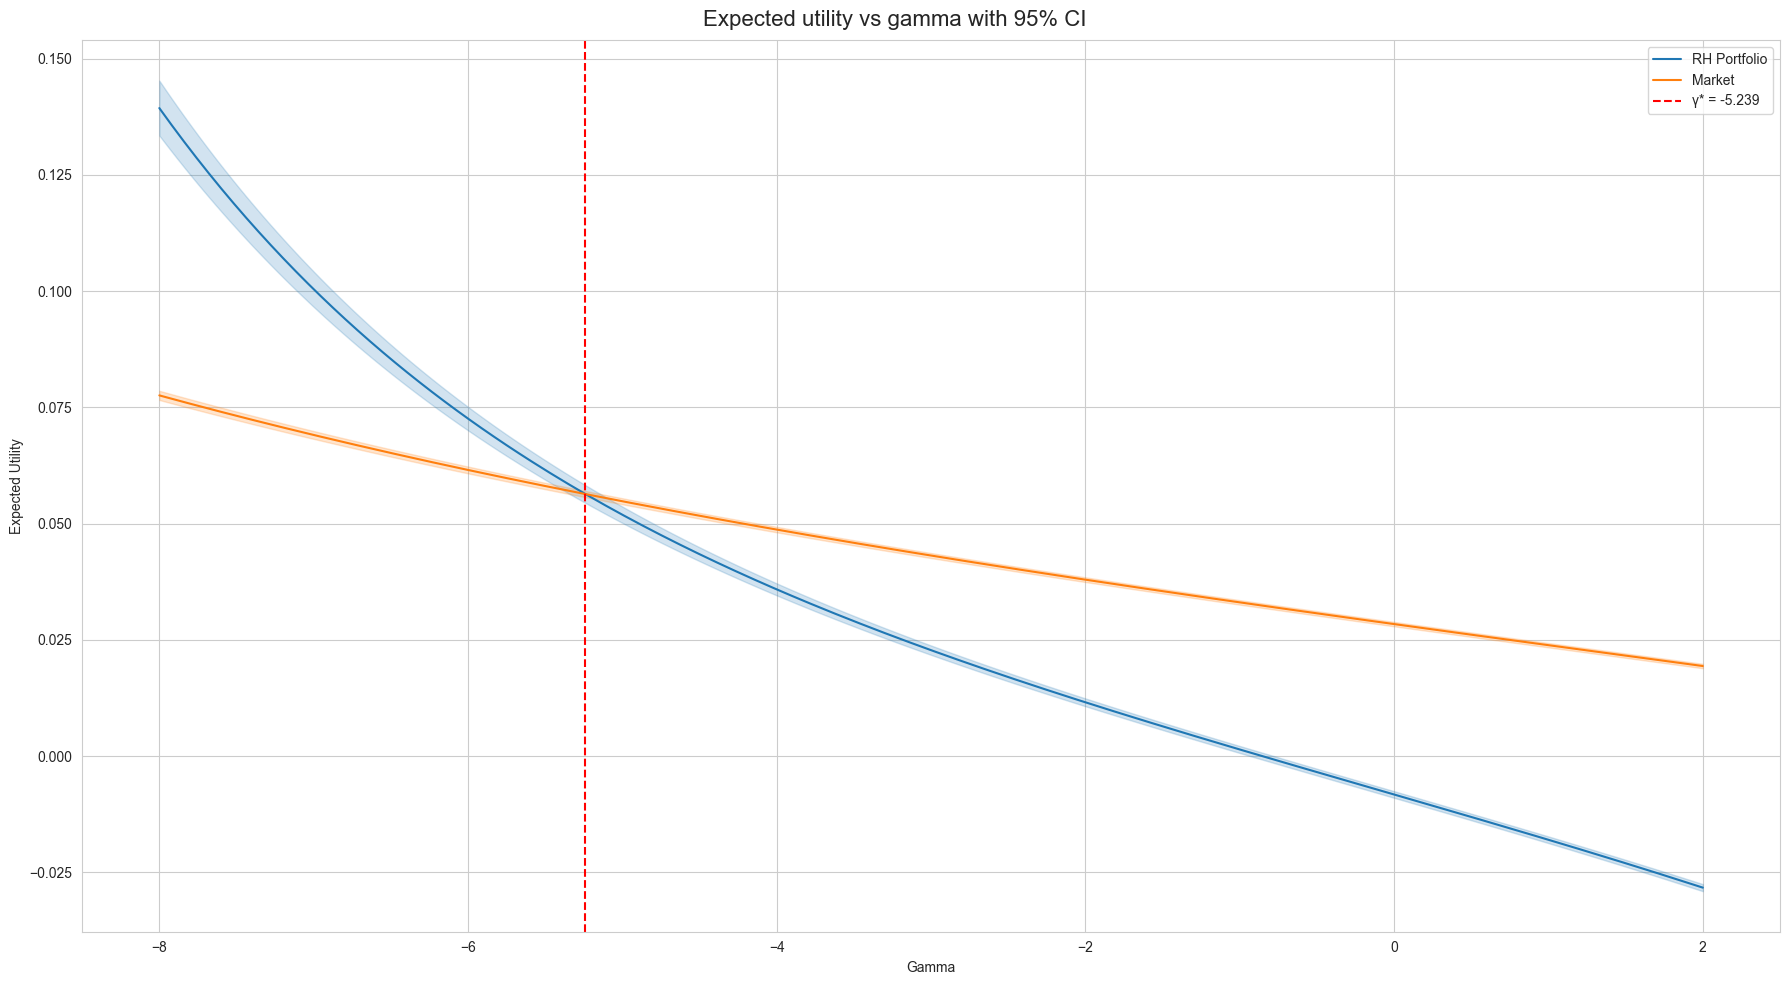

np.float64(-5.239166788859051)

In [12]:
rt.find_cutoff_gamma(df_returns=all_ret_df-1, bounds=(-8,2))

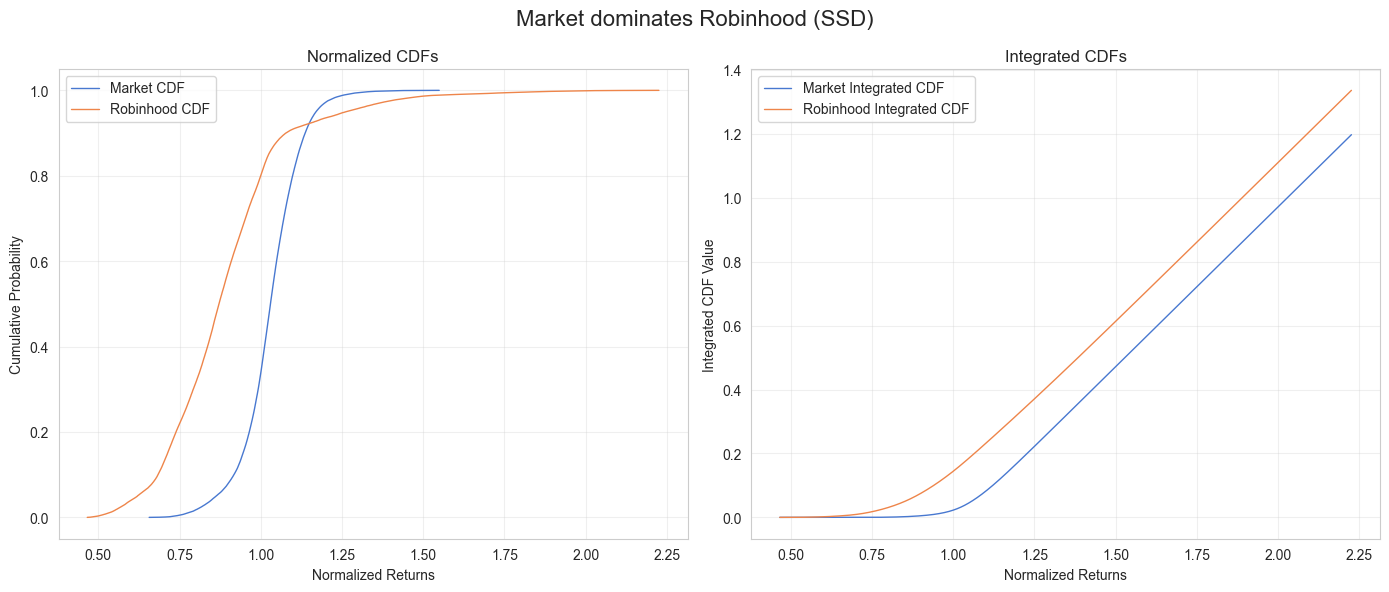

np.True_

In [7]:
from src.visuals.plotter import Plotter, ReturnSeries


plotter = Plotter([ReturnSeries(label="GMM", df=all_ret_df, horizons=[1])])
plotter.plot_ssd_comparison(all_ret_df["xmkt"], all_ret_df["xr"], "Market", "Robinhood")

**Can't do bootstrapping as it assumes independent samples**

## Euler

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams

import numpy as np

return_params = ReturnParams(
    horizons={},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=["VT"], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})


rt = RiskTests(an)
daily_factors = rt.factors
daily_factors.describe()

2025-05-01 23:54:06,481 - src.analyzer - INFO - ############################## Analysis Started ############################## (analyzer.py:80)


,rh_portfolio,rf,mkt,xr,xmkt
count,539.000000,539.000000,539.000000,539.000000,539.000000
mean,0.000609,0.000066,0.000225,0.000544,0.000159
std,0.020192,0.000033,0.015174,0.020195,0.015176
min,-0.117828,0.000000,-0.116411,-0.117888,-0.116471
25%,-0.006983,0.000060,-0.004676,-0.007065,-0.004756
50%,0.000725,0.000070,0.000886,0.000635,0.000822
75%,0.008794,0.000090,0.005888,0.008704,0.005793
max,0.102957,0.000100,0.091410,0.102897,0.091350


In [51]:
monnthly_factors = rt.resample_factors()
monnthly_factors

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-30,0.009446,0.001201,-0.007557,0.008236,-0.008748
2018-07-31,-0.002451,0.001681,0.035630,-0.004126,0.033894
2018-08-31,0.072512,0.001471,0.040571,0.070942,0.039045
2018-09-30,0.007566,0.001521,0.001237,0.006036,-0.000283
2018-10-31,-0.105207,0.001842,-0.068377,-0.106861,-0.070095
2018-11-30,0.001672,0.001681,0.018851,-0.000010,0.017142
2018-12-31,-0.107692,0.001902,-0.093380,-0.109396,-0.095110
2019-01-31,0.132882,0.001601,0.061908,0.131084,0.060217
2019-02-28,0.056941,0.001902,0.032499,0.054940,0.030542
2019-03-31,0.010753,0.001892,0.013551,0.008846,0.011638


In [4]:
gamma_gmm = rt.estimate_euler_gamma(df_returns=daily_factors)
gamma_gmm

np.float64(3.0714922378400455)

Gamma: 4.2207


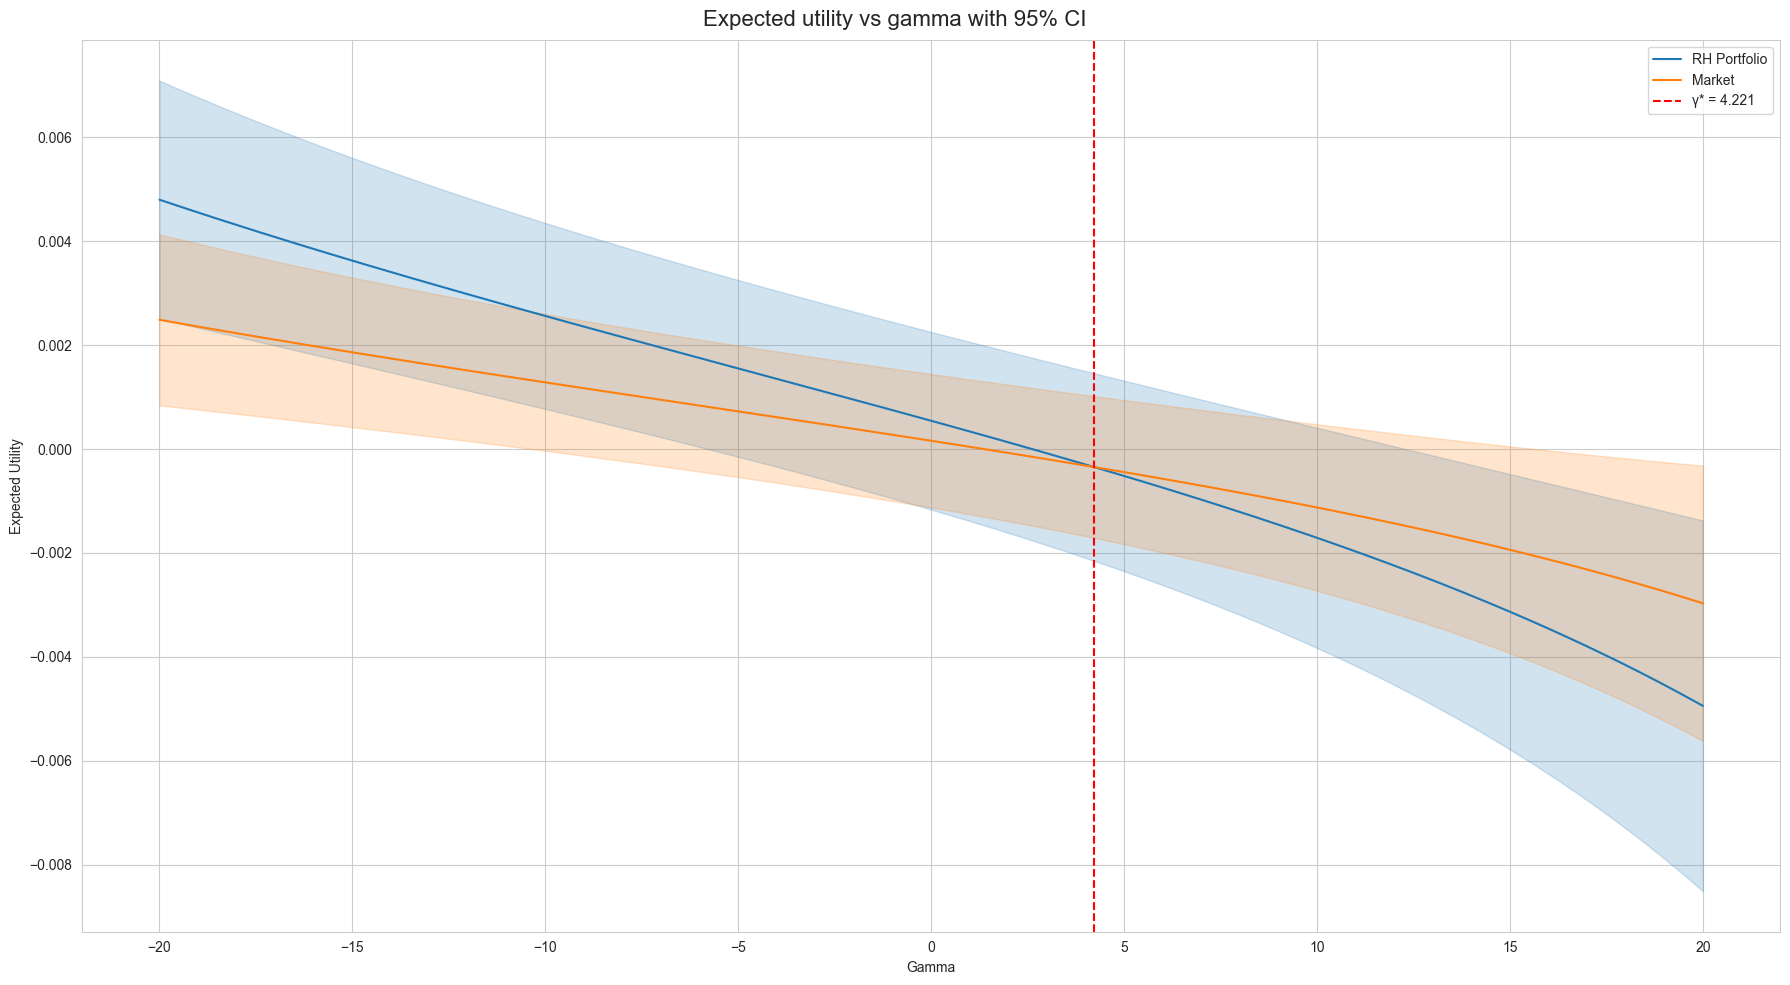

np.float64(4.22068367107366)

In [65]:
rt.find_cutoff_gamma()

In [3]:
df = daily_factors +1
df

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-04,1.007979,1.00006,1.005061,1.007919,1.005001
2018-06-05,1.007667,1.00006,0.999735,1.007607,0.999675
2018-06-06,1.009567,1.00006,1.008749,1.009507,1.008689
2018-06-07,0.995441,1.00006,0.996583,0.995381,0.996523
2018-06-08,1.003475,1.00006,1.002242,1.003415,1.002182
...,...,...,...,...,...
2020-08-07,0.996141,1.00000,0.996542,0.996141,0.996542
2020-08-10,1.019014,1.00000,1.002726,1.019014,1.002726
2020-08-11,0.980078,1.00000,0.996910,0.980078,0.996910
2020-08-12,1.006672,1.00000,1.015001,1.006672,1.015001


In [14]:
rt.bootstrap_difference_utility(df_returns=df, gamma0=gamma_gmm)

ΔU (xmkt - rh_portfolio) at γ=3.071: -0.00017 [-0.00097, 0.00061]


(np.float64(-0.00017284581852384324),
 np.float64(-0.0009742359888587294),
 np.float64(0.0006114926814635308))

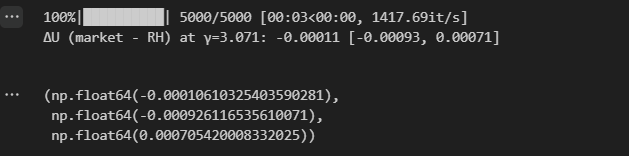

In [39]:
daily_factors

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-04,0.007979,0.00006,0.005061,0.007919,0.005001
2018-06-05,0.007667,0.00006,-0.000265,0.007607,-0.000325
2018-06-06,0.009567,0.00006,0.008749,0.009507,0.008689
2018-06-07,-0.004559,0.00006,-0.003417,-0.004619,-0.003477
2018-06-08,0.003475,0.00006,0.002242,0.003415,0.002182
...,...,...,...,...,...
2020-08-07,-0.003859,0.00000,-0.003458,-0.003859,-0.003458
2020-08-10,0.019014,0.00000,0.002726,0.019014,0.002726
2020-08-11,-0.019922,0.00000,-0.003090,-0.019922,-0.003090
2020-08-12,0.006672,0.00000,0.015001,0.006672,0.015001


In [114]:
rt.bootstrap_gamma(daily_factors)

γ̂^GMM = 3.0715
95% BCa CI = [0.9072, 19.8172]


{'gamma_estimate': np.float64(3.0714922378400455),
 'ci_lower': np.float64(0.9072428346440041),
 'ci_upper': np.float64(19.817195964133305),
 'confidence_level': 0.95,
 'n_resamples': 5000}

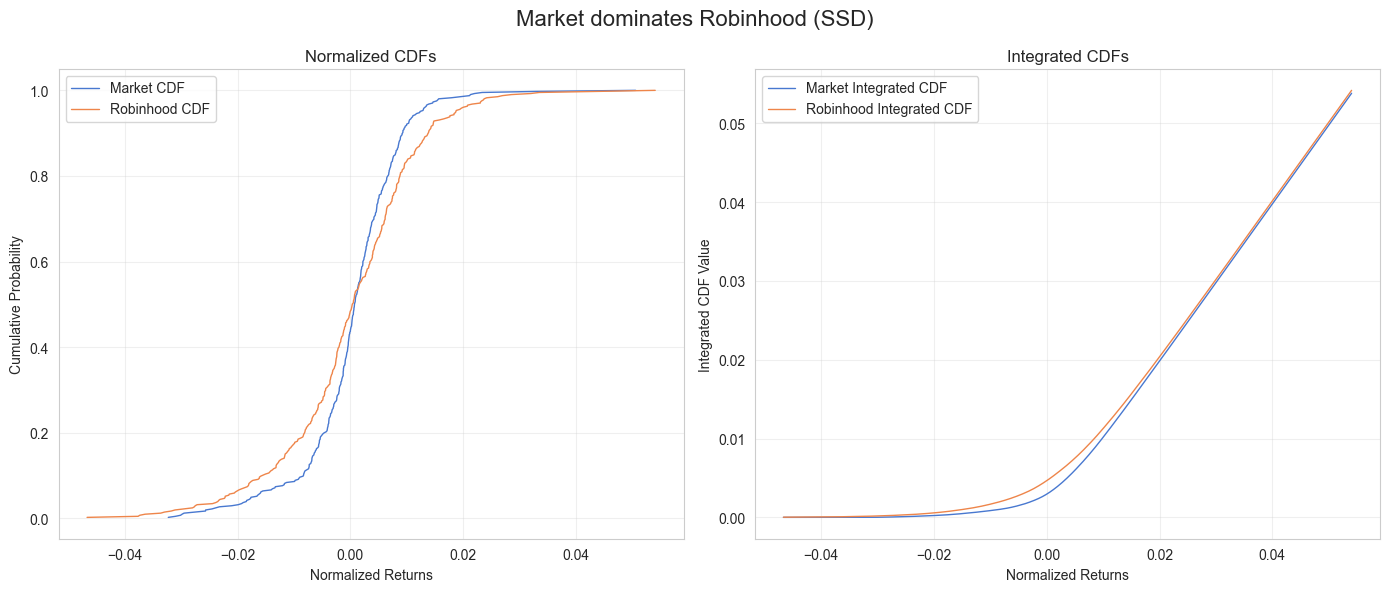

np.True_

In [45]:
from src.visuals.plotter import Plotter, ReturnSeries


plotter = Plotter([ReturnSeries(label="GMM", df=daily_factors, horizons=[])])
plotter.plot_ssd_comparison(daily_factors["mkt"], daily_factors["rh_portfolio"], "Market", "Robinhood")